In [105]:
import pandas as pd
from google.colab import files
import io
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

In [2]:
uploaded = files.upload()

Saving news.csv to news.csv


In [3]:
df = pd.read_csv(io.BytesIO(uploaded['news.csv']))

In [4]:
print(df.columns)
df["label"].replace({"REAL": 1, "FAKE": 0}, inplace=True)
y = df.iloc[:, -1]
df["new_text"] = df["title"] + df["text"]
X = df.iloc[:, -1]
print(y.value_counts(normalize=True))
X = np.array(X)
y = np.array(y)
#print(X)
#print(y)

Index(['Unnamed: 0', 'title', 'text', 'label'], dtype='object')
1    0.500552
0    0.499448
Name: label, dtype: float64


In [5]:
def length_dicsarding_space(text):
    return len(text) - text.count(' ')

In [6]:
max_features = 10000
#sequence_length = max(list(map(length_dicsarding_space, X)))
sequence_length = 25000
print(sequence_length)

25000


In [7]:
vectorize_layer = layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [8]:
vectorize_layer.adapt(X)

print(vectorize_layer(X[0]))

tf.Tensor([  39   64 8936 ...    0    0    0], shape=(25000,), dtype=int64)


In [9]:
vectorized_text = vectorize_layer(X)
#print(vectorized_text)
vectorized_text = np.array(vectorized_text)
print(vectorized_text.shape)

(6335, 25000)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(vectorized_text, y, test_size=.33, random_state=4)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=.33, random_state=42)

In [11]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(4244, 25000)
(1400, 25000)
(691, 25000)
(4244,)
(1400,)
(691,)


In [12]:
embedding_dim = 16

In [13]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

In [14]:
model.compile(loss=tf.losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy())

In [15]:
epochs = 100
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=epochs)

Epoch 1/100
133/133 [==============================] - 29s 213ms/step - loss: 2.0940 - binary_accuracy: 0.5014 - val_loss: 1.0688 - val_binary_accuracy: 0.4921
Epoch 2/100
133/133 [==============================] - 28s 207ms/step - loss: 0.9463 - binary_accuracy: 0.5014 - val_loss: 0.8588 - val_binary_accuracy: 0.4921
Epoch 3/100
133/133 [==============================] - 29s 215ms/step - loss: 0.8032 - binary_accuracy: 0.5014 - val_loss: 0.7514 - val_binary_accuracy: 0.4921
Epoch 4/100
133/133 [==============================] - 29s 218ms/step - loss: 0.7340 - binary_accuracy: 0.5038 - val_loss: 0.7081 - val_binary_accuracy: 0.4921
Epoch 5/100
133/133 [==============================] - 28s 207ms/step - loss: 0.7154 - binary_accuracy: 0.4823 - val_loss: 0.6963 - val_binary_accuracy: 0.4921
Epoch 6/100
133/133 [==============================] - 28s 207ms/step - loss: 0.7102 - binary_accuracy: 0.4979 - val_loss: 0.6922 - val_binary_accuracy: 0.4929
Epoch 7/100
133/133 [===================

In [16]:
loss, accuracy = model.evaluate(X_test, y_test)
print(loss)
print(accuracy)

22/22 [==============================] - 0s 21ms/step - loss: 0.3025 - binary_accuracy: 0.8726
0.3025490939617157
0.8726483583450317


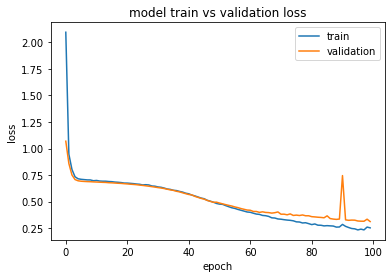

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

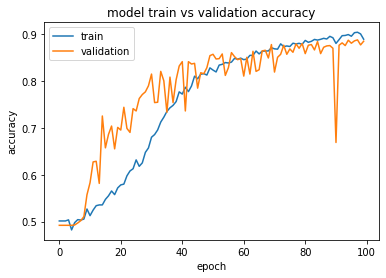

In [18]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model train vs validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

In [117]:
threshold = 0.5
y_pred = model.predict(X_test) 
y_pred05 = np.where(y_pred > threshold, 1,0)

22/22 [==============================] - 1s 25ms/step


In [118]:
confusion_matrix(y_test, y_pred05)

array([[321,  26],
       [ 62, 282]])

In [119]:
accuracy_score(y_test, y_pred05)

0.8726483357452967

In [120]:
f1_score(y_test, y_pred05)

0.8650306748466258

In [121]:
threshold = 0.4
y_pred04 = np.where(y_pred > threshold, 1,0)

In [123]:
confusion_matrix(y_test, y_pred04)

array([[307,  40],
       [ 40, 304]])

In [124]:
accuracy_score(y_test, y_pred04)

0.8842257597684515

In [125]:
f1_score(y_test, y_pred04)

0.8837209302325582

In [127]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred05).ravel()

In [128]:
print(fn)

62


In [129]:
fn_indices = [i for i, (x, y) in enumerate(zip(y_test, y_pred05)) if x == 1 and y == 0]
fp_indices = [i for i, (x, y) in enumerate(zip(y_test, y_pred05)) if x == 0 and y == 1]
tp_indices = [i for i, (x, y) in enumerate(zip(y_test, y_pred05)) if x == 1 and y == 1]
tn_indices = [i for i, (x, y) in enumerate(zip(y_test, y_pred05)) if x == 0 and y == 0]

In [130]:
print(len(fn_indices))
print(len(fp_indices))
print(len(tp_indices))
print(len(tn_indices))

62
26
282
321


In [ ]:
print(X_test[fn_indices])

In [133]:
fn_zeros = np.count_nonzero(X_test[fn_indices]==0, axis=1)
fp_zeros = np.count_nonzero(X_test[fp_indices]==0, axis=1)
tp_zeros = np.count_nonzero(X_test[tp_indices]==0, axis=1)
tn_zeros = np.count_nonzero(X_test[tn_indices]==0, axis=1)
print(fn_zeros)
print(fp_zeros)
print(tp_zeros)
print(tn_zeros)

[24756 24975 24234 23780 24638 24969 24977 24292 24393 24973 24880 24896
 24619 24785 24983 23927 24595 24658 24977 23947 23306 24240 24480 23938
 24978 24975 24938 24979 24922 24977 24933 24980 24924 24978 24969 24968
 24923 24520 24985 24915 24645 24395 24445 23670 23860 24307 24204 24905
 24931 24979 24976 24972 24889 24862 24945 24926 24209 24979 24980 24985
 24984 23804]
[24720 24423 24695 24636 23186 24671 24317 24727 23974 24562 24799 24674
 24739 24461 24207 18243 24631 24307 24281 24434 24738 24543 23910 24348
 24544 22767]
[23975 23630 24423 23751 24108 23910 24817 24398 24559 24150 24127 24002
 24611 24379 23726 24033 24247 24255 24632 24656 24497 24345 24435 24718
 24512 23963 24280 24002 24622 22884 24441 21801 24059 24577 20767 24393
 22559 24006 24349 22075 24672 24374 24300 23439 23956 24199 24326 23554
 24054 24743 24814 24030 24412 24046 23123 23799 23781 24773 24745 24345
 24892 23480 23953 24576 24259 23765 24304 24324 22522 23947 24395 23814
 24038 24569 23630 2431